In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pp

from datetime import datetime, timedelta
from stats_can import StatsCan

In [63]:
date_1 = '2014-08-03'
date_2 = '2018-07-29'

In [64]:
date_1_c = pd.Timestamp(date_1)
date_2_c = pd.Timestamp(date_2)

In [65]:
iv = pd.date_range(date_1_c, 
                   date_2_c, 
                   freq='W-SUN')

In [66]:
len(iv)

209

In [67]:
iv

DatetimeIndex(['2014-08-03', '2014-08-10', '2014-08-17', '2014-08-24',
               '2014-08-31', '2014-09-07', '2014-09-14', '2014-09-21',
               '2014-09-28', '2014-10-05',
               ...
               '2018-05-27', '2018-06-03', '2018-06-10', '2018-06-17',
               '2018-06-24', '2018-07-01', '2018-07-08', '2018-07-15',
               '2018-07-22', '2018-07-29'],
              dtype='datetime64[ns]', length=209, freq='W-SUN')

In [41]:
df = pd.DataFrame()

In [42]:
df['date'] = iv

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 0 to 65
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    66 non-null     datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 656.0 bytes


In [44]:
# Function to pull economic data from Statistics Canada



# sc = StatsCan()
# econ_df = sc.vectors_to_df_remote('v2062815', periods = 360)
# econ_df.columns = ['unemployment_rate']
# econ_df = econ_df.reset_index()

# econ_df['refPer_yr_mth'] = [item for item in zip(econ_df['refPer'].dt.year, econ_df['refPer'].dt.month)]
    
# df['date_row_yr_mth'] = [item for item in zip(df['date'].dt.year, df['date'].dt.month)]

# data_vectors_dict = {'Monthly GDP Growth Rate (Annualised)': 'v65201210', 
#                      'Monthly Inflation Rate (Annualised)': 'v41690973', 
#                      'Unemployment Rate':'v2062815'}

def append_monthly_unemployment_rate(df, date_row):
    sc = StatsCan() # Instantiate StatsCan object
    econ_df = sc.vectors_to_df_remote('v2062815', periods = 360) # Pull monthly unemployment rate
    econ_df.columns = ['unemployment_rate']
    econ_df = econ_df.reset_index()
    
    # 
    econ_df['refPer_yr_mth'] = [item for item in zip(econ_df['refPer'].dt.year, econ_df['refPer'].dt.month)]
    
    df['date_row_yr_mth'] = [item for item in zip(df[date_row].dt.year, df[date_row].dt.month)]
    
    df_merge_orig_gdp = pd.merge(df, 
                                econ_df, 
                                how = 'left', 
                                left_on='date_row_yr_mth', 
                                right_on='refPer_yr_mth')
    
    df_merge_orig_gdp = df_merge_orig_gdp.loc[:,['date', 'unemployment_rate']]
    
    return df_merge_orig_gdp


In [45]:
df = append_monthly_unemployment_rate(df, 'date')

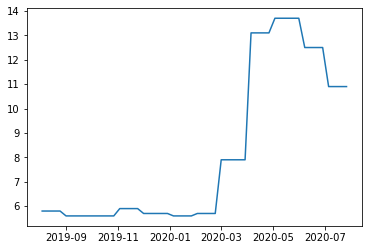

In [11]:
pp.plot(df['date'], df['unemployment_rate'])

In [60]:
def make_dataframe(start_date, end_date, include_econ_indicators=True):
        '''
        When function is called, returns a Pandas dataframe with time interval every sunday 
        including the first one before the `start_date` and the last one before `end_date`.
        start_date, end_date: input in the yyyy-mm-dd format
        include_econ_indicators: True by default. Pulls unemployment, monthly CPI, and monthly GDP data from Statistics Canada using stats_can API
        TO-DO: GDP: True by default. Pulls monthly GDP  from Statistics Canada using stats_can API
        '''
        start_date_ts = pd.Timestamp(start_date)
        end_date_ts = pd.Timestamp(end_date)

        df = pd.DataFrame()
        df['date'] = pd.date_range(start_date_ts, end_date_ts, freq = 'W-SUN')
        df['date_row_yr_mth'] = [item for item in zip(df['date'].dt.year, df['date'].dt.month)]

        if include_econ_indicators:
            sc = StatsCan()
            unem_df = sc.vectors_to_df_remote('v2062815', periods = 360)
            unem_df.columns = ['unemployment_rate']
            unem_df = unem_df.reset_index()

            gdp_df = sc.vectors_to_df_remote('v65201210', periods = 360)
            gdp_df.columns = ['monthly_gdp']
            gdp_df = gdp_df.reset_index()
            
            cpi_df = sc.vectors_to_df_remote('v41690973', periods = 360)
            cpi_df.columns = ['monthly_cpi']
            cpi_df = cpi_df.reset_index()

            econ_df = pd.merge(unem_df, gdp_df, on='refPer', how='inner')
            econ_df = econ_df.merge(cpi_df, on='refPer')
            
            econ_df['refPer_yr_mth'] = [item for item in zip(econ_df['refPer'].dt.year, econ_df['refPer'].dt.month)]
            
            df_merge_orig_gdp = pd.merge(df, 
                                    econ_df, 
                                    how = 'inner', 
                                    right_on='refPer_yr_mth',
                                    left_on='date_row_yr_mth')
        
            df_merge_orig_gdp = df_merge_orig_gdp.drop(['refPer_yr_mth','date_row_yr_mth','refPer'], axis = 1)

            return df_merge_orig_gdp

        else:
            return df

In [61]:
make_dataframe(date_1, date_2)

,date,unemployment_rate,monthly_gdp,monthly_cpi
0,2014-08-03,7.0,1809135.0,125.7
1,2014-08-10,7.0,1809135.0,125.7
2,2014-08-17,7.0,1809135.0,125.7
3,2014-08-24,7.0,1809135.0,125.7
4,2014-08-31,7.0,1809135.0,125.7
...,...,...,...,...
204,2018-07-01,5.8,1952354.0,134.3
205,2018-07-08,5.8,1952354.0,134.3
206,2018-07-15,5.8,1952354.0,134.3
207,2018-07-22,5.8,1952354.0,134.3


In [53]:
data = pd.read_csv('../data_cleaned.csv')
data

,wk_strt_dt,yr_nbr,qtr_nbr,prd,wk_nbr,wk_in_yr_nbr,mdip_dm,mdip_inst,mdip_nsp,mdip_auddig,...,st_ct,mrkdn_valadd_edw,mrkdn_pdm,va_pub_0.15,va_pub_0.2,va_pub_0.25,va_pub_0.3,Electronics,unemployment_rate,is_holiday_week
0,2014-08-03,2014,3,7,1,27,4863885,29087520,2421933,692315,...,716.285714,0.000000,0.368029,1,0,0,0,63,7.0,0
1,2014-08-10,2014,3,7,2,28,20887502,8345120,3984494,475810,...,716.428571,0.000000,0.360911,1,0,0,0,54,7.0,0
2,2014-08-17,2014,3,7,3,29,11097724,17276800,1846832,784732,...,717.000000,0.000000,0.344832,1,1,0,0,54,7.0,0
3,2014-08-24,2014,3,7,4,30,1023446,18468480,2394834,1032301,...,717.000000,0.000000,0.356973,1,1,0,0,45,7.0,0
4,2014-08-31,2014,3,8,1,31,21109811,26659920,3312008,400456,...,717.000000,0.000000,0.359990,0,1,0,0,52,7.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,2018-07-01,2018,2,5,5,22,13038,13828188,387,2135131,...,599.000000,0.415964,0.371423,0,1,0,0,41,5.8,1
205,2018-07-08,2018,2,6,1,23,0,3714294,0,1448480,...,599.000000,0.457615,0.372676,0,1,1,0,45,5.8,1
206,2018-07-15,2018,2,6,2,24,2225092,5102353,0,1307764,...,599.000000,0.382469,0.363597,0,0,1,0,47,5.8,0
207,2018-07-22,2018,2,6,3,25,17544331,1478566,1891,510539,...,599.000000,0.272084,0.360448,0,1,0,0,44,5.8,0


In [54]:
data.columns

Index(['wk_strt_dt', 'yr_nbr', 'qtr_nbr', 'prd', 'wk_nbr', 'wk_in_yr_nbr',
       'mdip_dm', 'mdip_inst', 'mdip_nsp', 'mdip_auddig', 'mdip_audtr',
       'mdip_vidtr', 'mdip_viddig', 'mdip_so', 'mdip_on', 'mdip_em',
       'mdip_sms', 'mdip_aff', 'mdip_sem', 'mdsp_dm', 'mdsp_inst', 'mdsp_nsp',
       'mdsp_auddig', 'mdsp_audtr', 'mdsp_vidtr', 'mdsp_viddig', 'mdsp_so',
       'mdsp_on', 'mdsp_sem', 'sales', 'me_ics_all', 'me_gas_dpg', 'st_ct',
       'mrkdn_valadd_edw', 'mrkdn_pdm', 'va_pub_0.15', 'va_pub_0.2',
       'va_pub_0.25', 'va_pub_0.3', 'Electronics', 'unemployment_rate',
       'is_holiday_week'],
      dtype='object')

In [55]:
data['wk_strt_dt']

0      2014-08-03
1      2014-08-10
2      2014-08-17
3      2014-08-24
4      2014-08-31
          ...    
204    2018-07-01
205    2018-07-08
206    2018-07-15
207    2018-07-22
208    2018-07-29
Name: wk_strt_dt, Length: 209, dtype: object

## Holidays in week leading up to date

In [16]:
import holidays

In [17]:
ca_holidays = holidays.Canada()

In [32]:
pd.Timestamp('2019-01-01') in ca_holidays

True

In [33]:
pd.Timestamp('2019-01-01') - 7

TypeError: Addition/subtraction of integers and integer-arrays with Timestamp is no longer supported.  Instead of adding/subtracting `n`, use `n * obj.freq`

In [26]:
iv_d = pd.date_range(pd.Timestamp('2019-01-01'), 
                   pd.Timestamp('2019-01-01'), 
                   freq='D', 
                   closed='right')

In [27]:
iv_d

DatetimeIndex(['2019-08-02', '2019-08-03', '2019-08-04', '2019-08-05',
               '2019-08-06', '2019-08-07', '2019-08-08', '2019-08-09',
               '2019-08-10', '2019-08-11',
               ...
               '2020-07-23', '2020-07-24', '2020-07-25', '2020-07-26',
               '2020-07-27', '2020-07-28', '2020-07-29', '2020-07-30',
               '2020-07-31', '2020-08-01'],
              dtype='datetime64[ns]', length=366, freq='D')